In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from shapely.ops import unary_union
import warnings, platform
warnings.filterwarnings('ignore')

radios = gpd.read_file("https://bitsandbricks.github.io/data/CABA_rc.geojson")
print(radios.crs)
print(radios.head())

print("Filas:", len(radios))
print("Geometrías vacías:", radios.geometry.is_empty.sum())
print("Geometrías nulas:", radios.geometry.isna().sum())

EPSG:4326
  RADIO_ID       BARRIO COMUNA  POBLACION  VIVIENDAS  HOGARES  HOGARES_NBI  \
0    1_1_1       RETIRO      1      336.0       82.0     65.0         19.0   
1   1_12_1  SAN NICOLAS      1      341.0      365.0    116.0         25.0   
2  1_12_10  SAN NICOLAS      1      296.0      629.0    101.0          1.0   
3  1_12_11  SAN NICOLAS      1      528.0      375.0    136.0          7.0   
4   1_12_2  SAN NICOLAS      1      229.0      445.0    129.0         16.0   

   AREA_KM2                                           geometry  
0  1.798997  MULTIPOLYGON (((-58.37189 -34.59199, -58.37202...  
1  0.018565  MULTIPOLYGON (((-58.38593 -34.60444, -58.38575...  
2  0.044380  MULTIPOLYGON (((-58.37879 -34.60528, -58.37741...  
3  0.366340  MULTIPOLYGON (((-58.36733 -34.60562, -58.36713...  
4  0.018363  MULTIPOLYGON (((-58.38454 -34.60436, -58.38311...  
Filas: 3554
Geometrías vacías: 0
Geometrías nulas: 0


In [2]:
radios_m = radios.to_crs(epsg=3857)

radios_m["area_m2"] = radios_m.geometry.area
radios_m["densidad_hab_km2"] = radios_m["POBLACION"] / (radios_m["area_m2"] / 1e6)

In [4]:
import time
import os
from pathlib import Path
import geopandas as gpd

# Carpeta de salida
OUT_DIR = Path("results") / "io_performance"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Guardar versión "original" en GeoJSON
geojson_path = OUT_DIR / "barrios_m_original.geojson"
radios_m.to_file(geojson_path, driver="GeoJSON")

# 2) Guardar versión optimizada en GeoParquet
parquet_path = OUT_DIR / "barrios_m_geoparquet.parquet"
radios_m.to_parquet(parquet_path)

# 3) Crear versión simplificada de geometrías
barrios_simpl = radios_m.copy()
barrios_simpl["geometry"] = barrios_simpl.geometry.simplify(
    tolerance=50,                # ajustar si querés más/menos detalle
    preserve_topology=True
)

parquet_simpl_path = OUT_DIR / "barrios_m_geoparquet_simpl.parquet"
barrios_simpl.to_parquet(parquet_simpl_path)

# Función auxiliar para medir tiempo de lectura
def medir_tiempo_lectura(path, reader):
    t0 = time.perf_counter()
    gdf = reader(path)
    t1 = time.perf_counter()
    return gdf, t1 - t0

# 4) Medir tamaños de archivo (MB)
def size_mb(path):
    return os.path.getsize(path) / (1024**2)

size_geojson   = size_mb(geojson_path)
size_parquet   = size_mb(parquet_path)
size_parquet_s = size_mb(parquet_simpl_path)

print("TAMAÑOS DE ARCHIVO (MB)")
print(f"- GeoJSON original     : {size_geojson:.2f} MB")
print(f"- GeoParquet           : {size_parquet:.2f} MB")
print(f"- GeoParquet simplificado: {size_parquet_s:.2f} MB")

# 5) Medir tiempos de lectura
print("\nTIEMPOS DE LECTURA (segundos)")

# GeoJSON con geopandas.read_file
_, t_geojson = medir_tiempo_lectura(geojson_path, gpd.read_file)
print(f"- GeoJSON (read_file)        : {t_geojson:.4f} s")

# GeoParquet con geopandas.read_parquet
_, t_parquet = medir_tiempo_lectura(parquet_path, gpd.read_parquet)
print(f"- GeoParquet (read_parquet)  : {t_parquet:.4f} s")

# GeoParquet simplificado
_, t_parquet_s = medir_tiempo_lectura(parquet_simpl_path, gpd.read_parquet)
print(f"- GeoParquet simplificado    : {t_parquet_s:.4f} s")

# 6) Comparación rápida
print("\nRESUMEN:")
ratio_size_parquet = size_parquet / size_geojson if size_geojson > 0 else float("nan")
ratio_size_simpl   = size_parquet_s / size_geojson if size_geojson > 0 else float("nan")

print(f"- GeoParquet pesa ~{ratio_size_parquet:.2f}× el GeoJSON (menor es mejor).")
print(f"- GeoParquet simplificado pesa ~{ratio_size_simpl:.2f}× el GeoJSON.")
print(f"- Aceleración lectura Parquet vs GeoJSON ≈ {t_geojson / t_parquet:.2f}×")
print(f"- Aceleración lectura Parquet simplificado vs GeoJSON ≈ {t_geojson / t_parquet_s:.2f}×")


TAMAÑOS DE ARCHIVO (MB)
- GeoJSON original     : 4.43 MB
- GeoParquet           : 0.79 MB
- GeoParquet simplificado: 0.33 MB

TIEMPOS DE LECTURA (segundos)
- GeoJSON (read_file)        : 0.3934 s
- GeoParquet (read_parquet)  : 0.6083 s
- GeoParquet simplificado    : 0.0290 s

RESUMEN:
- GeoParquet pesa ~0.18× el GeoJSON (menor es mejor).
- GeoParquet simplificado pesa ~0.07× el GeoJSON.
- Aceleración lectura Parquet vs GeoJSON ≈ 0.65×
- Aceleración lectura Parquet simplificado vs GeoJSON ≈ 13.57×


In [5]:
import time
import os
from pathlib import Path
import geopandas as gpd

# Carpeta de salida
OUT_DIR = Path("results") / "io_performance"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Guardar versión "original" en GeoJSON
geojson_path = OUT_DIR / "barrios_m_original.geojson"
radios_m.to_file(geojson_path, driver="GeoJSON")

# 2) Guardar versión optimizada en GeoParquet
parquet_path = OUT_DIR / "barrios_m_geoparquet.parquet"
radios_m.to_parquet(parquet_path)

# 3) Crear versión simplificada de geometrías
barrios_simpl = radios_m.copy()
barrios_simpl["geometry"] = barrios_simpl.geometry.simplify(
    tolerance=50,                # ajustar si querés más/menos detalle
    preserve_topology=True
)

parquet_simpl_path = OUT_DIR / "barrios_m_geoparquet_simpl.parquet"
barrios_simpl.to_parquet(parquet_simpl_path)

# Función auxiliar para medir tiempo de lectura
def medir_tiempo_lectura(path, reader):
    t0 = time.perf_counter()
    gdf = reader(path)
    t1 = time.perf_counter()
    return gdf, t1 - t0

# 4) Medir tamaños de archivo (MB)
def size_mb(path):
    return os.path.getsize(path) / (1024**2)

size_geojson   = size_mb(geojson_path)
size_parquet   = size_mb(parquet_path)
size_parquet_s = size_mb(parquet_simpl_path)

print("TAMAÑOS DE ARCHIVO (MB)")
print(f"- GeoJSON original     : {size_geojson:.2f} MB")
print(f"- GeoParquet           : {size_parquet:.2f} MB")
print(f"- GeoParquet simplificado: {size_parquet_s:.2f} MB")

# 5) Medir tiempos de lectura
print("\nTIEMPOS DE LECTURA (segundos)")

# GeoJSON con geopandas.read_file
_, t_geojson = medir_tiempo_lectura(geojson_path, gpd.read_file)
print(f"- GeoJSON (read_file)        : {t_geojson:.4f} s")

# GeoParquet con geopandas.read_parquet
_, t_parquet = medir_tiempo_lectura(parquet_path, gpd.read_parquet)
print(f"- GeoParquet (read_parquet)  : {t_parquet:.4f} s")

# GeoParquet simplificado
_, t_parquet_s = medir_tiempo_lectura(parquet_simpl_path, gpd.read_parquet)
print(f"- GeoParquet simplificado    : {t_parquet_s:.4f} s")

# 6) Comparación rápida
print("\nRESUMEN:")
ratio_size_parquet = size_parquet / size_geojson if size_geojson > 0 else float("nan")
ratio_size_simpl   = size_parquet_s / size_geojson if size_geojson > 0 else float("nan")

print(f"- GeoParquet pesa ~{ratio_size_parquet:.2f}× el GeoJSON (menor es mejor).")
print(f"- GeoParquet simplificado pesa ~{ratio_size_simpl:.2f}× el GeoJSON.")
print(f"- Aceleración lectura Parquet vs GeoJSON ≈ {t_geojson / t_parquet:.2f}×")
print(f"- Aceleración lectura Parquet simplificado vs GeoJSON ≈ {t_geojson / t_parquet_s:.2f}×")


TAMAÑOS DE ARCHIVO (MB)
- GeoJSON original     : 4.43 MB
- GeoParquet           : 0.79 MB
- GeoParquet simplificado: 0.33 MB

TIEMPOS DE LECTURA (segundos)
- GeoJSON (read_file)        : 0.3964 s
- GeoParquet (read_parquet)  : 0.0454 s
- GeoParquet simplificado    : 0.0326 s

RESUMEN:
- GeoParquet pesa ~0.18× el GeoJSON (menor es mejor).
- GeoParquet simplificado pesa ~0.07× el GeoJSON.
- Aceleración lectura Parquet vs GeoJSON ≈ 8.74×
- Aceleración lectura Parquet simplificado vs GeoJSON ≈ 12.14×


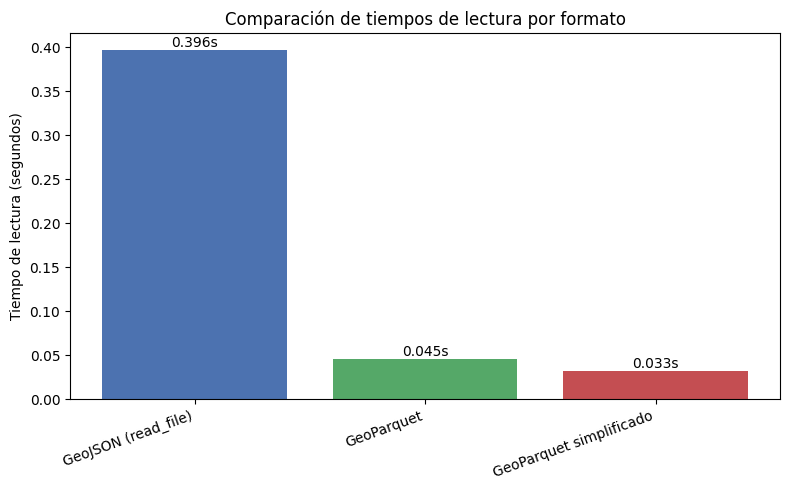

In [9]:
metodos = [
    "GeoJSON (read_file)",
    "GeoParquet",
    "GeoParquet simplificado"
]

tiempos = [t_geojson, t_parquet, t_parquet_s]

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(metodos))
ax.bar(x, tiempos, color=["#4c72b0", "#55a868", "#c44e52"])

# Etiquetas y formato
ax.set_xticks(x)
ax.set_xticklabels(metodos, rotation=20, ha="right")
ax.set_ylabel("Tiempo de lectura (segundos)")
ax.set_title("Comparación de tiempos de lectura por formato")

# Mostrar el valor encima de cada barra
for i, v in enumerate(tiempos):
    ax.text(i, v, f"{v:.3f}s", ha="center", va="bottom")

plt.tight_layout()
plt.show()

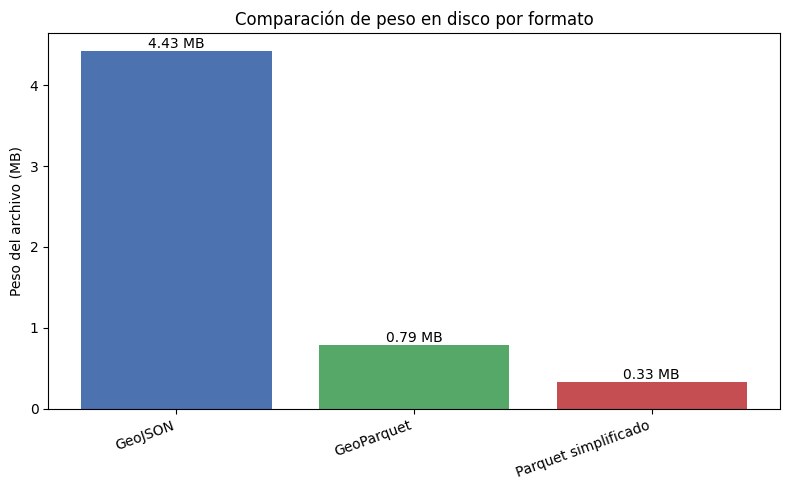

In [10]:
formatos = [
    "GeoJSON",
    "GeoParquet",
    "Parquet simplificado"
]

pesos = [size_geojson, size_parquet, size_parquet_s]  # en MB

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(formatos))
ax.bar(x, pesos, color=["#4c72b0", "#55a868", "#c44e52"])

# Etiquetas y formato
ax.set_xticks(x)
ax.set_xticklabels(formatos, rotation=20, ha="right")
ax.set_ylabel("Peso del archivo (MB)")
ax.set_title("Comparación de peso en disco por formato")

# Mostrar valores sobre cada barra
for i, v in enumerate(pesos):
    ax.text(i, v, f"{v:.2f} MB", ha="center", va="bottom")

plt.tight_layout()
plt.show()